### Setup Maya for VQA

In [ ]:
# Global Variables (Model, Tokenizer, Image Processor)
model_base = "CohereForAI/aya-23-8B"
model_path = "maya-multimodal/maya" # toxicity-free: nahidalam/maya_toxicity_free_finetuned
mode = "finetuned"  # Options: 'finetuned' or 'pretrained'
projector_path = None  # Required if mode is 'pretrained'

In [ ]:
import torch
import os
from PIL import Image
import matplotlib.pyplot as plt
import textwrap


from llava.constants import (
    IMAGE_TOKEN_INDEX,
    DEFAULT_IMAGE_TOKEN,
    DEFAULT_IM_START_TOKEN,
    DEFAULT_IM_END_TOKEN,
)
from llava.conversation import conv_templates
from llava.eval.maya.eval_utils import load_maya_model
from llava.utils import disable_torch_init
from llava.mm_utils import tokenizer_image_token, process_images

# Disable Torch initialization to save memory
disable_torch_init()


def load_model(model_base, model_path, mode="finetuned", projector_path=None):
    """
    Load the Maya model along with tokenizer and image processor.
    """
    if mode == "finetuned" and projector_path is not None:
        print(
            "******** Warning: Projector path is provided but will not be used in 'finetuned' mode ********"
        )
    if mode == "pretrained" and projector_path is None:
        raise ValueError("Error: Projector path is required when mode is 'pretrained'")

    model, tokenizer, image_processor, _ = load_maya_model(
        model_base, model_path, projector_path if mode == "pretrained" else None, mode
    )

    # Move model to GPU and set to evaluation mode
    model = model.half().cuda()
    model.eval()

    return model, tokenizer, image_processor


# Load the model (only do this once)
model, tokenizer, image_processor = load_model(
    model_base=model_base,
    model_path=model_path,
    mode=mode,
    projector_path=projector_path,
)


def validate_image_file(image_path):
    """
    Validate that the image file exists and is in a supported format.

    Parameters:
    - image_path (str): Path to the image file.

    Returns:
    - bool: True if the file is valid, False otherwise.
    """
    if not os.path.isfile(image_path):
        print(f"Error: File {image_path} does not exist.")
        return False

    try:
        # Try opening the file with PIL to confirm it's a valid image
        with Image.open(image_path) as img:
            img.verify()  # Verify that it's a proper image format
        return True
    except (IOError, SyntaxError) as e:
        print(f"Error: {image_path} is not a valid image file. {e}")
        return False


import textwrap


def run_vqa_model(
    image_file, question, conv_mode="aya", temperature=0.2, top_p=None, num_beams=1
):
    """
    Perform Visual Question Answering on a specified image file.

    Parameters:
    - image_file (str): Path to the image file.
    - conv_mode (str): Conversation mode template to use.
    - temperature (float): Sampling temperature.
    - top_p (float): Nucleus sampling probability.
    - num_beams (int): Number of beams for beam search.
    - question (str): The question to ask about the image.

    Returns:
    - answer (str): The model's answer to the question.
    """
    # Validate the image file
    if not validate_image_file(image_file):
        raise FileNotFoundError(
            f"Error: Invalid or non-existent image file {image_file}."
        )

    # Prepare the prompt
    if model.config.mm_use_im_start_end:
        prompt_question = (
            DEFAULT_IM_START_TOKEN
            + DEFAULT_IMAGE_TOKEN
            + DEFAULT_IM_END_TOKEN
            + "\n"
            + question
        )
    else:
        prompt_question = DEFAULT_IMAGE_TOKEN + "\n" + question

    conv = conv_templates[conv_mode].copy()
    conv.append_message(conv.roles[0], prompt_question)
    conv.append_message(conv.roles[1], None)
    prompt = conv.get_prompt()

    input_ids = (
        tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt")
        .unsqueeze(0)
        .cuda()
    )

    # Open and process the image
    image = Image.open(image_file).convert("RGB")
    image_tensor = process_images([image], image_processor, model.config)[0]

    # Plot the image
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis("off")
    plt.title("Input Image")
    plt.show()

    # Generate the answer using the model
    with torch.inference_mode():
        output_ids = model.generate(
            input_ids,
            images=image_tensor.unsqueeze(0).half().cuda(),
            image_sizes=[image.size],
            do_sample=True if temperature > 0 else False,
            temperature=temperature,
            top_p=top_p,
            num_beams=num_beams,
            max_new_tokens=4096,
            use_cache=True,
        )

    # Decode the output tokens to a string and wrap text for display
    answer = tokenizer.batch_decode(output_ids, skip_special_tokens=True)[0].strip()
    wrapped_answer = textwrap.fill(answer, width=80)  # Adjust width as needed

    # Display the question and wrapped answer
    print("*" * 80)
    print(f"Q: {question}\nA: {wrapped_answer}")
    print("*" * 80)

    return answer

### Example Run

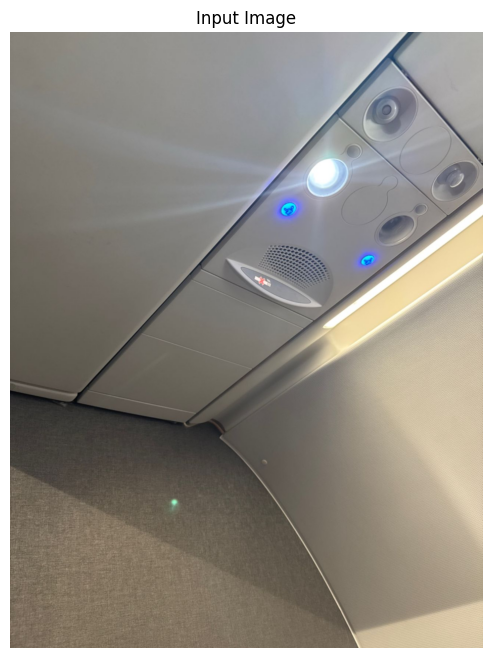

********************************************************************************
Q: Try identify what plane this is, based on the design.
A: Based on the image, the plane appears to be a modern aircraft with a white
exterior. The presence of blue lights on the ceiling suggests that it could be a
jetliner, possibly a commercial airliner. The design and features of the plane
indicate that it might be a modern, efficient aircraft, commonly used for air
travel. However, without more specific details, it is difficult to determine the
exact make and model of the plane.
********************************************************************************


In [9]:
# Run the VQA model
generated_answer = run_vqa_model(
    question="Try identify what plane this is, based on the design.",
    image_file = "./claude_plane_test_2.jpeg"  # Current directory
)

